# Преффиксное дерево, Ахо-Корасик и их применение в языковым моделях
Существует две наиболее универсальные структуры данных для хранения произвольных объектов -- это хэш-таблицы и бинарные деревья поиска. Для хранения строк с целью какого-либо последующего поиска интересны графовые структуры, вот например

In [1]:
from graph_utils.graph import Node, Arc, Graph
from animation_utils.animation import animate_list, animate_dict

In [2]:
def simple_tree(words):
    arcs = []
    root = 0
    state = 1
    for word in words:
        prev = root
        for letter in word:
            arcs.append(Arc(prev, state, letter))
            prev = state
            state += 1
    return Graph(arcs)        

In [3]:
words = [
    'мама',
    'мыла',
    'раму',
    'мылом',
]

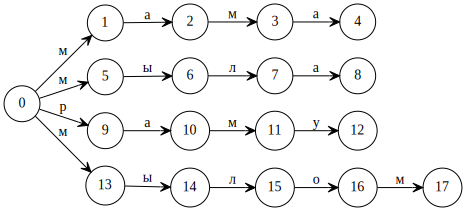

In [4]:
simple_tree(words).Visualize()

Каждому слову в списке соответствует путь в этом графе из $0$ до некоторого листа и наоборот, конкатенируя символы, написанные на переходах мы получаем исходные слова. Само по себе это дерево не имеет ценности, зато имеет его более компактный вариант -- преффиксное дерево. Ключевое соображение заключается в следующем: вершины $1, 5, 13$ можно объединить, так как переходы $0\rightarrow 1, 0\rightarrow 5, 0\rightarrow 13$ помечены одним и тем же символом, после такого объединения набор строк на путях от корня к листьям не поменяется. Если попробовать выжать как можно больше из этого соображения, то мы получим <i><b>преффиксное дерево</b> (trie, prefix tree)</i>.

In [5]:
class TrieNode:
    def __init__(self, parent, word=None):
        # Хранение этого поля очень расточительно, используется исключительно
        # для демонстрации ленивого подсчета суффиксных ссылок
        self.parent = parent
        # Здесь аналогично, это поле чаще всего избыточно
        self.word = word
        self.children = {}
        self.suff_link = None

In [6]:
def init_trie():
    trie = [TrieNode(-1)]
    return trie

In [7]:
def add_word(trie, word):
    _num = 0
    for ch in word:
        if not ch in trie[_num].children:
            _n = len(trie)
            trie[_num].children[ch] = _n
            trie.append(TrieNode((_num, ch)))
        _num = trie[_num].children[ch]
    trie[_num].word = word

In [8]:
def make_trie(words):
    trie = init_trie()
    for word in words:
        add_word(trie, word)
    return trie

In [9]:
def to_graph(trie):
    arcs = []
    for i, node in enumerate(trie):
        for c, nextstate in node.children.items():
            arcs.append(Arc(i, nextstate, c))
        if node.suff_link is not None and node.suff_link != 0:
            arcs.append(Arc(i, 
                            node.suff_link, 
                            attributes={"constraint" : "False", "style" : "dashed"}))
            
    return Graph(arcs)

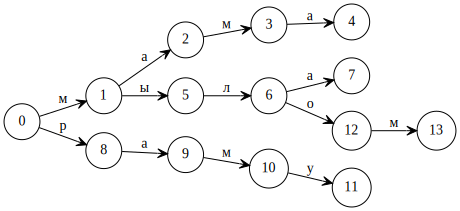

In [10]:
trie = make_trie(words)
to_graph(trie).Visualize()

В терминах конечных автоматов процедура получения этого дерева из простого, изображенного ранее -- это детерминизация. В случае набора слов эта процедура довольно тривиально и её проще поддерживать по мере добавления слова, в процедуре add_word мы сначала пройдем некоторую часть слова, которая уже есть в дереве, а потом создадим ответвление специально под добавляемое слово. В общем случае (регулярные языки) ипользуется специальный алгоритм  построение [супермножества](https://en.wikipedia.org/wiki/Powerset_construction). Так или иначе, преффиксное дерево обладает ключевым свойством: из одного состояния не может быть 2 и более переходов, помеченных одинаковым символом. Это свойство позволяет делать эффективный поиск по дереву

In [11]:
# Для визуализации
def init(graph):
    graph.nodes[0].SetColor('blue')

def step_forward(graph, node, letter):
    node.SetColor('green')    
    for arc in node.arcs:
        if arc.weight == letter or (arc.weight is None and (letter is None or letter == "")):
            arc.SetColor('green')
            graph.nodes[arc.end].SetColor('blue')
            return
    # Хак, связанный с визуализацией суффиксных ссылок
    graph.nodes[0].SetColor('blue')

def fail(graph):
    for node in graph.nodes.values():
        if node.attributes['color'] != 'black':
            node.SetColor('red')
        for arc in node.arcs:
            if arc.attributes['color'] != 'black':
                arc.SetColor('red')
                
def finish_find(node):
    node.SetColor('green')
                
def reset(graph):
    for node in graph.nodes.values():
        node.SetColor('black')
        for arc in node.arcs:
            arc.SetColor('black')
    
######################################

def find(trie, word):
    graph = to_graph(trie)
    init(graph)
    slices = [graph.Visualize()]
    
    state = 0
    for letter in word:
        if letter in trie[state].children:
            step_forward(graph, graph.nodes[state], letter)
            slices.append(graph.Visualize())
            ###
            state = trie[state].children[letter]            
        else:
            fail(graph)
            slices.append(graph.Visualize())
            reset(graph)
            return (False, slices)
        
    if trie[state].word != word:
        fail(graph)
        slices.append(graph.Visualize())
        reset(graph)
        return(False, slices)
    finish_find(graph.nodes[state])
    slices.append(graph.Visualize())
    reset(graph)
    return (True, slices)

In [12]:
result, slices = find(trie, 'рама')
print(result)
animate_list(slices);

False


interactive(children=(IntSlider(value=0, description='idx', max=4), Output()), _dom_classes=('widget-interact'…

Здесь стоит отметить, что при поиске следующей вершины нужно каким-то образом искать ребро по соответствующей букве. Это возвращает нас к хэш таблицам и бинарным деревьям поиска. Стоит отметить, однако, что набор символом заранее известен и ограничен, что довольно сильно облегчает задачу поиска. В итоге поиск строки разбивается на несколько последовательных поисков символов в небольших таблицах, кроме того в случае отстутствия искомого слова в дереве мы просматриваем строку не целиком а только ту часть, которая в дереве содержится. В случае с хеш таблицей мы делаем подсчет хеша -- обычно это линейный проход по строке, -- один запрос поиска по хешу и финальное честное сравнение строк в случае совпадения хешей.

# Алгоритм Ахо-Корасик
Основная задача, которую решает этот алгоритм: "дан набор слов и строка. Нужно в строке найти все вхождения слов из словаря". Важно то, что строка -- это не текст, который разбивается на слова, нужно искать именно как подстроки. Самый простой способ решить эту задачу -- по очереди пытаться найти каждое из слов, пытаясь сопоставить слово всем подстрокам нужной длины

In [13]:
search_words = ['ма', 'мы', 'ам', 'рама']
sentence = 'мама мыла раму'

In [14]:
def find_substrings_simple(words, sentence):
    result = dict()
    comparison_count = 0
    n = len(sentence)
    for word in words:
        # Сюда будем складывать интервалы, соответствующие подстрокам равным word
        intervals = []
        for i in range(n - len(word) + 1):
            match = True
            for j, letter in enumerate(word):
                comparison_count += 1
                if letter != sentence[i + j]:
                    match = False
                    break
            if match:
                intervals.append((i, i + len(word)))
        result[word] = intervals
    return (result, comparison_count)                

In [15]:
result, comparison_count = find_substrings_simple(search_words, sentence)
print(sentence)
print('Number of character comparisons:', comparison_count)
for word, intervals in result.items():
    print(word, end=':')
    print(', '.join(map(str, intervals)))

мама мыла раму
Number of character comparisons: 65
ма:(0, 2), (2, 4)
мы:(5, 7)
ам:(1, 3), (11, 13)
рама:


Представления множества в виде преффиксного дерева уже сильно помогает ускорить этот базовый подход. Если немного перегруппировать проверки в базовом подходе (поменять местами два внешних цикла), то получается, что мы по очереди для каждой позиции пытаемся проверить, не соответствует ли подстроки, начинающиеся в этой позиции искомым словам? Эту группу проверок можно сделать гораздо быстее с помощью преффиксного дерева, достаточно использовать процедуру на подобие той, что мы делали для поиска

In [16]:
def match_at_position(trie, sentence, position):
    slices = []
    graph = to_graph(trie)
    init(graph)
    slices.append(graph.Visualize())
    state = 0
    matched_words = []
    comparisons = 0
    for i in range(position, len(sentence)):
        comparisons += 1
        if sentence[i] in trie[state].children:
            step_forward(graph, graph.nodes[state], sentence[i])
            slices.append(graph.Visualize())
            
            state = trie[state].children[sentence[i]]
        else:
            fail(graph)
            slices.append(graph.Visualize())
            break
        
        if trie[state].word is not None:
            matched_words.append(trie[state].word)
            
    return (matched_words, slices, comparisons)

def match_suffix(trie, sentence):
    return match_at_position(trie, sentence, position=0)

In [17]:
def find_substrings_trie(words, sentence):
    search_trie = make_trie(words)
    suffixes = [sentence[i:] for i in range(len(sentence))]
    
    visualization_result = {}
    result = {}
    
    comparison_total = 0
    for i, suffix in enumerate(suffixes):
        matched_words, slices, comparisons_pos = match_suffix(search_trie, suffix)
        comparison_total += comparisons_pos
        for word in matched_words:
            if word not in result:
                result[word] = []
            result[word].append((i, i + len(word)))
        visualization_result[suffix] = slices
        
    return (result, visualization_result, comparison_total)

In [18]:
result, visualization_result, comparison_total = find_substrings_trie(search_words, sentence)
    
# Сложность построения преффикс-дерева линейно по суммарной длине всех входящих в него слов
print('Total number of letters in searched words:', sum(map(len, search_words)))
print('Number of character dictionary queries:', comparison_total)
for word, intervals in result.items():
    print(word, end=':')
    print(', '.join(map(str, intervals)))

Total number of letters in searched words: 10
Number of character dictionary queries: 30
ма:(0, 2), (2, 4)
ам:(1, 3), (11, 13)
мы:(5, 7)


In [19]:
animate_dict(visualization_result, 'Суффикс');

interactive(children=(Select(description='Суффикс', options=('мама мыла раму', 'ама мыла раму', 'ма мыла раму'…

Что более важно, в этом подходе возможно использовать сравнения, которые были сделаны на предыдущих суффиксах, чтобы аккуратно к этому прейти стоит сначала разобрать случай, когда мы ищем только одно слово

## Преффикс функция
Одной из ключевых концепций, ведущих к эффективным алгоритмам поиска подстрок, является <i><b>преффикс-функция</b></i>. Для строки $S=[S_0, S_1, \ldots, S_{n-1}]$ преффкс-функция $P$ определяется как
$$
P[i]=\max\{~j~|~j\leq i,~S[0:j]=S[i-j+1:i+1]~\}
$$
Иначе говоря $P[i]$ -- это максимальная длина нетривиального суффикса, который совпадает с преффиксом. Например для строки `abacaba` преффикс функция выглядит следующим образом
$$
abacaba
$$
$$
0010123
$$
Если мы каким-то образом смогли вычислить преффикс-функцию, то с её помощью мы можем довольно легко без дополнительных сравнений получить все суффиксы, совпадающие с преффиксами, причем в убывающем порядке. По определенияю $P[i]$
$$
S[0:P[i]]=S[i-P[i]+1:i+1]
$$
Учитывая посмотрим на преффикс-функцию в позиции $P[i]-1$:
$$
S[0:P[P[i]-1]]=S[P[i]-P[P[i]-1]:P[i]]=S[i-P[P[i]-1]+1:i+1]
$$
Первое равенство выполняется в силу $P[P[i]-1]$, второе -- в силу $P[i]$. Вот пример на строке `abacaba`: $P[6]=3$, т.е. $S[0:3]=S[4:7]$. При этом $P[2]=1$, что указывает на то, что $S[0:1]=S[6:7]$. Ключевой момент здесь заключается в том, что $P[P[i]-1]$ дает нам наибольший префикс, совпадающиий с суффиксом для $P[i]-1$, а значит также указывает на следующий по возрастанию. Таким образом длины всех возможных совпадающих преффиксов-суффиксов в позиции $i$ -- это $P[i]\rightarrow P[P[i]-1] \rightarrow P[P[P[i]-1]-1]\rightarrow \ldots$.

У преффикс-функции есть еще одно очень простое свойство
$$
P[i]\leq P[i-1]+1.
$$
Следует это из очень простого факта
$$
S[0:P[i]]=S[i-P[i]+1:i+1]\Rightarrow S[0:P[i]-1]=S[i-P[i]+1:i]
$$
Этих двух свойств достаточно, чтобы эффективно вычислить преффикс функцию слева направо наподобие динамическому программированию: если мы посчитали $P$ для $0\ldots i$, то для подсчета $P[i+1]$ нужно взять максимальный совпадающий с суффиксом преффикс для $i$ такой, что следующий за ним символ совпадает с $S[i+1]$. При этом мы умеем перебирать совпадающие преффиксы-суффиксы в убывающем по длине порядке, поэтому первый, который нам попадется с совпадением следующего символа -- это нужный нам преффикс.

In [20]:
def preffix_function(s):
    p = [0]
    k = 0
    for letter in s[1:]:
        while k > 0 and s[k] != letter:
            k = p[k - 1]
        if s[k] == letter:
            k += 1
        p.append(k)
    return p

In [21]:
s = 'abacaba'
print(s)
print(''.join(map(str, preffix_function(s))))

abacaba
0010123


### Анализ скорости работы
Несмотря на вложенный цикл оказывается, что эта процедура линейна по количеству символов в `s`. Дело в том, что `k` может увеличиваться на каждой итерации внешнего цикла не более, чем на единицу в строке (в условном операторе), а уменьшаться только при `k = p[k - 1]`. Из этого следует, что количество итераций внутреннего цикла суммарно не превосходит длину строки.

### Поиск подстроки в строке с помощью преффикс-функции
Самый простой способ использовать преффикс-функцию для поиска вхождений `t` в качестве подстроки `s` -- это посчитать преффикс-функцию для строки `t#s`, где `#` -- это какой-то символ, который гарантированно не встречается ни в `s`, ни в `t`. Тогда очевидно, что значения преффикс-функции не могут превышать длину `t` и при этом позиции, где значения достигают длины `t` соответствтуют вхождениям `t` в `s`. Тем не менее можно поступить более разумно, не строить дополнительную строку, а построить преффикс-функцию только для `t`, после чего пройтись с её помощью по `s`. Это довольно известный подход, его обычно называют алгоритмом <i><b>Кнута-Морриса-Пратта</b></i>.

In [22]:
def find_substring_kmp(s, t):
    result = []
    m = len(t)
    
    p = preffix_function(t)
    k = 0
    
    for i, letter in enumerate(s):
        while k > 0 and t[k] != letter:
            k = p[k - 1]
        if s[k] == letter:
            k += 1
        if k == m:
            result.append((i - k + 1, i + 1))
            k = p[k - 1]
    return result

In [23]:
print(search_words[0])
print(sentence)
print(find_substring_kmp(sentence, search_words[0]))

ма
мама мыла раму
[(0, 2), (2, 4)]


## Обобщение преффикс-функции на случай нескольких строк
Основная идея алгоритма Кнута-Морриса-Пратта заключается в том, чтобы для каждой позиции `i` строки `s` считать максимальную длину суффикса, совпадающего с преффиксом `t`, в этом нам помогает предподсчет преффикс-функции для `t`. Преффикс-функция имеет естественное обобщение на преффиксное дерево: каждой вершине дерева соответствует некоторая строка, давайте для каждой вершины посчитаем другую, которая соответствует наибольшему нетривиальному суффиксу этой строки, это и будет наш аналог преффикс-функции для дерева. Полученные переходы обычно называют суффиксными ссылками, они обладают все теми же двумя свойствами, что и преффикс-функция, по считать её можно так же по аналогии начиная с наиболее близких вершин постепенно переходя к более дальним (в порядке обхода в ширину): допустим мы пытаемся посчитать суффиксную ссылку $v$, к которой ведет переход $u\rightarrow v$, помеченный символом `c`. Достаточно переходить по уже посчитанным суффиксным ссылкам начиная с $u$, пока не упремся в корень или не найдем вершину, из которой есть переход по `c`, итоговая вершина и будет соответствовать суффиксной ссылке $v$. Альтернативным эффективным способом является рекурсия с запоминанием: в первый раз когда мы делаем запрос на подсчет суффиксной ссылки -- вычисляем её и запоминаем, чтобы в следующий раз выдать уже посчитанный результат, попутно при вычислениях используем эту логику для тех суффиксных ссылок, который нам нужны для подсчета. У этого алгоритма есть недостаток: необходимо помнить родителя вершины.

In [24]:
from queue import Queue
# Подсчет всех ссылок обходом в ширину
def calc_suff_links_all(trie):
    q = Queue()
    q.put(0)
    trie[0].suff_link = 0
    while not q.empty():
        cur = q.get()
        for letter, child in trie[cur].children.items():
            if cur == 0:
                trie[child].suff_link = 0
            else:
                _tmp = trie[cur].suff_link
                while _tmp != 0:
                    if letter in trie[_tmp].children:
                        break
                    _tmp = trie[_tmp].suff_link
                if letter in trie[_tmp].children:
                    _tmp = trie[_tmp].children[letter]
                trie[child].suff_link = _tmp
            q.put(child)
        

# Рекурсивная реализация подсчета одной суффиксной ссылки, использует поле parent
def calc_suff_link(trie, i):
    if i == 0:
        return 0
    if not trie[i].suff_link is None:
        return trie[i].suff_link
    _p = trie[i].parent[0]
    _ch = trie[i].parent[1]
    if _p == 0:
        trie[i].suff_link = 0
        return 0
    _tmp = calc_suff_link(trie, _p)
    while _tmp != 0:
        if _ch in trie[_tmp].children:
            break
        _tmp = calc_suff_link(trie, _tmp)
    if _ch in trie[_tmp].children:
        _tmp = trie[_tmp].children[_ch]
    trie[i].suff_link = _tmp
    return _tmp

In [25]:
trie = make_trie(words)
calc_suff_links_all(trie)

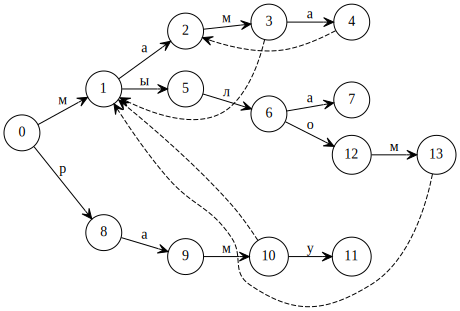

In [26]:
to_graph(trie).Visualize()

Суффиксные ссылки обозначены пунктирными линиями, для того, чтобы рисунок был чище, суффиксные ссылки, ведущие в корень, не отображены. Наконец осталось проделать аналогичную процедуру на строке, в которой мы что-то ищем

In [27]:
def find_substrings_aho_corasick(words, sentence):
    search_trie = make_trie(words)
    calc_suff_links_all(search_trie)
    graph = to_graph(search_trie)
    init(graph)
        
    result = dict()
    slices = [graph.Visualize()]
    comparison_count = 0
    
    state = 0
    for i, letter in enumerate(sentence):
        reset(graph)
        graph.nodes[state].SetColor("blue")
        # Здесь код структурно немного отличается от реализации Кнута-Морриса-Пратта выше, чтобы
        # избежать лишнего сравнения, так как здесь сравнения мы используем в качестве меры
        # качества алгоритма
        while state != 0:
            comparison_count += 1
            if letter not in search_trie[state].children:
                step_forward(graph, graph.nodes[state], "")
            
                ###
                state = search_trie[state].suff_link
            else:
                need_check = False
                break
        
        if state == 0:
            comparison_count += 1
            if letter in search_trie[state].children:
                step_forward(graph, graph.nodes[state], letter)
                state = search_trie[state].children[letter]
        else:
            step_forward(graph, graph.nodes[state], letter) 
            state = search_trie[state].children[letter]


        slices.append(graph.Visualize())
        
        # Здесь важно пройтись по всем суффиксным ссылкам, потому что в одной позиции
        # могут заканчиваться несколько искомых подстрок. Все они как раз генерируются 
        # проходом по суффиксным ссылкам
        tmp = state
        while tmp != 0:
            if search_trie[tmp].word is not None:
                if search_trie[tmp].word not in result:
                    result[search_trie[tmp].word] = []
                result[search_trie[tmp].word].append((i - len(search_trie[tmp].word) + 1, i + 1))
            tmp = search_trie[tmp].suff_link
    return (result, slices, comparison_count)

In [28]:
result, slices, comparison_count = find_substrings_aho_corasick(search_words, sentence)

print('Total number of letters in searched words:', sum(map(len, search_words)))
print('Number of character dictionary queries:', comparison_count)
for word, intervals in result.items():
    print(word, end=':')
    print(', '.join(map(str, intervals)))
print(sentence)
animate_list(slices);

Total number of letters in searched words: 10
Number of character dictionary queries: 23
ма:(0, 2), (2, 4)
ам:(1, 3), (11, 13)
мы:(5, 7)
мама мыла раму


interactive(children=(IntSlider(value=0, description='idx', max=14), Output()), _dom_classes=('widget-interact…

## Анализ
Для первого внутреннего цикла работает тот же аргумент, что и для поиска по преффикс функции, поэтому суммарное число итераций в нем не превосходит длины строки. Для второго ситуация сложнее. На самом деле для "красивой" оценки второй внутренний цикл стоит немного изменить при помощи предподсчета. Дело в том, что этот цикл нужно ровно для случаев, когда несколько искомых слов заканчиваются в одной позиции, например если бы мы искали `ма` и `мама` в `мама мыла раму`. Все эти слова можно легко найти, проитерировався по суффиксным ссылкам, но при этом некоторые суффиксы будут соответствовать искомым словам, а некоторые нет. Предподсчитать последовательность переходов по суффиксным ссылкам, ведущим к следующему слову, довольно легко и в этом случае сложность алгоритма будет линейна по суммарной длине всех слов и размеру результата.

# Примеры
## Исправление ошибок при наборе текста на клавиатуре
Предположим, что мы печаем какой-то текст, иногда совершаем ошибки и хотим их по возможности исправлять автоматически. Зная правильно написанные слова мы можем сделать простую модель: каждый раз набирая очередной символ мы с некоторой вероятностью делаем ошибку, с некоторой вероятностью набираем правильный символ. При этом, если мы знаем, какие правильное написание слов, то можем испкать наиболее вероятную последовательность слов с помощью динамического программирования. Далее я приведу пример, как это можно сделать, используя эвристику "лучевого поиска" на большом словаре.

In [29]:
import requests, zipfile, io
import os
# Раскоментируйте следующий код, чтобы скачать и распаковать словарь
# url='http://www.ruscorpora.ru/new/ngrams/1grams-3.zip'
# r = requests.get(url)
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall('data/dict_ru')

In [30]:
min_freq = 30
trie_dict_ru = init_trie()
with open('data/dict_ru/1grams-3.txt', encoding='utf-8') as f:
    for line in f:
        freq, word = line.split()
        if int(freq) < min_freq:
            break
        add_word(trie_dict_ru, word)

In [31]:
prob_mistake = 0.1
space_insert_likelihood = prob_mistake / 30
probs = {'S' : prob_mistake / 3, 'D' : prob_mistake / 3, 'I': prob_mistake / 3, 'C' : 1.0 - prob_mistake}
from numpy import log
print(log(probs['S']))

-3.4011973816621555


In [32]:
from weakref import WeakValueDictionary

# Класс для хранения словных гипотез
class HistoryItem:
    def __init__(self, word, prev=None, lm_state=None):
        self.word = word
        self.prev = prev
        self.state = lm_state
        # Чтобы не мучаться с удалением гипотез, которые умерли
        self.next = WeakValueDictionary()
        
    def prolong(self, word, next_lm_state = None):
        if word not in self.next:
            new_item = HistoryItem(word, self, next_lm_state)
            self.next[word] = new_item
            return new_item
        else:
            return self.next[word]   
        
    def backtrace(self):
        result = [self.word]
        _tmp = self.prev
        while _tmp is not None:
            if _tmp.word is not None:
                result.append(_tmp.word)
            _tmp = _tmp.prev
        return reversed(result)

In [33]:
# Для визуализации процесса поиска гипотез
def hypothesis_tree(tokens):
    arcs = []
    tmp = tokens[0][2]
    while tmp is not None and tmp.prev is not None:
        tmp = tmp.prev
    
    q = Queue()
    q.put((tmp, 0))
    states = 1
    while not q.empty():
        history_item, num = q.get()
        for word, next_item in history_item.next.items():
            q.put((next_item, states))
            arcs.append(Arc(num, states, word))
            states += 1
                   
    return Graph(arcs).Visualize()

Далее идет основная процедура, в случае обычного динамического программирования у нас отсутствовали условия вида `neg_log_prob < best_neg_log_prob + beam`, иначе говоря в некоторые моменты времени мы отсекаем неправдоподобные гипотезы.

In [34]:
def correct_text_with_beam_search(trie, text, lm=None, lm_scale=1.0, beam=10.0):
    hyp_slices = []
    tokens = Queue()
    root = HistoryItem(None, None, None if lm is None else lm.start)
    tokens.put((0, 0.0, root))
    prev_best_neg_log_prob = 0.0
    for letter in text:
        #print(letter)
        new_tokens = dict()
        best_neg_log_prob = float('inf')
        
        new_tokens[0] = (float('inf'), None)
        
        # Для обработки "вставки" лишнего символа нужен какой-то механизм изменения
        # tokens, альтернатно можно использовать dict и обрабатывать состояния в возрастающем
        # (топологическом) порядке
        while not tokens.empty():
            item = tokens.get()
            state, neg_log_prob, history_item = item
            
            if state not in new_tokens:
                new_tokens[state] = (float('inf'), None)
            if new_tokens[state][0] > neg_log_prob - log(probs['D']):
                new_tokens[state] = (neg_log_prob - log(probs['D']), history_item)
                best_neg_log_prob = min(best_neg_log_prob, neg_log_prob - log(probs['D']))
            if letter == ' ' and trie[state].word is not None:
                new_cost = neg_log_prob
                if lm is not None:
                    next_lm_state, lm_costs = lm.consume_word(history_item.state, trie[state].word)
                    lm_cost = sum(lm_costs)
                    new_cost += lm_cost * lm_scale
                if new_tokens[0][0] > new_cost:
                    if lm is not None:
                        new_tokens[0] = (new_cost, history_item.prolong(trie[state].word, next_lm_state))
                    else:
                        new_tokens[0] = (new_cost, history_item.prolong(trie[state].word))
            for char, nextstate in trie[state].children.items():
                if nextstate not in new_tokens:
                    new_tokens[nextstate] = (float('inf'), None)
                if letter != char and new_tokens[nextstate][0] > neg_log_prob - log(probs['S']) \
                        and neg_log_prob - log(probs['S']) < best_neg_log_prob + beam:
                    new_tokens[nextstate] = (neg_log_prob - log(probs['S']), history_item)
                    best_neg_log_prob = min(best_neg_log_prob, neg_log_prob - log(probs['S']))
                if letter == char and new_tokens[nextstate][0] > neg_log_prob - log(probs['C']) \
                        and neg_log_prob - log(probs['C']) < best_neg_log_prob + beam:
                    new_tokens[nextstate] = (neg_log_prob - log(probs['C']), history_item)
                    best_neg_log_prob = min(best_neg_log_prob, neg_log_prob - log(probs['C']))
                if neg_log_prob - log(probs['I']) < prev_best_neg_log_prob + beam:
                    tokens.put((nextstate, neg_log_prob - log(probs['I']), history_item))

        
        # Отдельно обрабатываем возможную вставку пробела, потому что при пробеле должно заканчиваться слово
        for state, item in new_tokens.items():
            neg_log_prob, history_item = item
            if history_item is None:
                continue
            new_cost = neg_log_prob - log(space_insert_likelihood)
            if lm is not None:
                next_lm_state, lm_costs = lm.consume_word(history_item.state, trie[state].word)
                lm_cost = sum(lm_costs)
                new_cost += lm_cost * lm_scale
                
            if trie[state].word is not None and new_tokens[0][0] > new_cost:
                if lm is not None:
                    new_tokens[0] = (new_cost, 
                                     history_item.prolong(trie[state].word, next_lm_state))
                else:
                    new_tokens[0] = (new_cost, 
                                     history_item.prolong(trie[state].word))
                
        tokens = Queue()
        tokens_list = []
        best_token = None
        for state, item in new_tokens.items():
            if item[0] <= best_neg_log_prob + beam:
                tokens.put((state, *item))
                tokens_list.append((state, *item))                
            if best_token is None or item[0] < best_token[1]:
                best_token = (state, *item)
        prev_best_neg_log_prob = best_neg_log_prob
        
        hyp_slices.append(hypothesis_tree(tokens_list))
    
    result = []
    while not tokens.empty():
        result.append(tokens.get())
               
    return result, hyp_slices

In [35]:
def recover_best_hyp(tokens):
    best_token = min([token for token in tokens if token[0] == 0], key=lambda x: x[1])
    return best_token[2].backtrace()

In [36]:
tokens, hyp_slices = correct_text_with_beam_search(trie_dict_ru, 'я напсалэто предложеtние с незначительнми ошибкми', beam=7.0)

In [37]:
print(list(recover_best_hyp(tokens)))

['я', 'напал', 'это', 'предложение', 'с', 'незначительными', 'ошибки']


Как видно слова теперь написаны правильно и довольно близко к исходному тексту, но все еще не то, что подразумевалось исходным текстом, в таких случаях помогает языковые модели.

In [38]:
animate_list(hyp_slices, play=True);

Play(value=0)

interactive(children=(IntSlider(value=0, description='idx', max=48), Output()), _dom_classes=('widget-interact…

# $N$-грамные языковые модели
В общем смысле языковая модель (ЯМ) -- это вероятнастная модель, оценивающая правдоподобие тех или иных последовательностей символов над некоторым алфавитом, обычно вероятность последовательности декомпозируется в произведение вероятностей отдельных символов следующим образом
$$
P(w_1, \ldots, w_n)=\prod_{i=1}^nP(w_i~|~w_1, \ldots, w_{i-1}),
$$
иначе говоря вероятность последовательностей символов -- это произведение вероятностьей всех символов при условии их левых контекстов. $N$-грамные ЯМ относятся к марковским моделям и ограничивают возможный контекст до $N-1$, гдe $N$ -- порядок ЯМ
$$
P(w_1, \ldots, w_n)=\prod_{i=1}^nP(w_i~|~w_{i-N+1}, \ldots, w_{i-1}).
$$
Базовые процесс обучения $N$-грамной ЯМ заключается в том, чтобы посчитать на некотором текстовом корпусе количества встренных последовательностей слов длины вплоть до $N$ и обучить ЯМ методом максимального правдоподобия: если $C(w_1, \ldots, w_k)$ -- количество раз, сколько последовательность слов $w_1, \ldots, w_k$ встретилась в тексте, то формулы максимального правдоподобия выглядят следующим образом
$$
P(w_i~|~w_{i-k+1}, \ldots, w_{i-1})=\frac{C(w_{i-k+1}, \ldots, w_{i-1}, w_{i})}{\sum_w C(w_{i-k+1}, \ldots, w_{i-1}, w)}.
$$
Проблема этого базового подхода заключается в довольно серьезном переобучении: вероятность любой $N$-грамы, которой не было в обучающем тексте равняется нулю. Чтобы как-то решить эту проблему обычно используют следующую модификации для формулы вероятности
$$
P(w_i~|~w_{i-k+1}, \ldots, w_{i-1})=
\begin{cases}
\frac{C(w_{i-k+1}, \ldots, w_{i-1}, w_{i})}{\sum_w C(w_{i-k+1}, \ldots, w_{i-1}, w)}, & C(w_{i-k+1}, \ldots, w_{i-1}, w_{i}) > 0 \\
P(w_i~|~w_{i-k+2}, \ldots, w_{i-1}) * b(w_{i-k+2}, \ldots, w_{i-1}), & C(w_{i-k+1}, \ldots, w_{i-1}, w_{i}) = 0
\end{cases}
$$
т.е. в случае наличия данной последовательности в исходном тексте вероятность последовательности оценивается как обычно, в противном случае мы пытаемся оценить вероятность последовательно усекая контекст. Здесь $b(\cdot)$ -- так называемый <b>backoff weight</b> или просто <b>backoff</b>, величина $b(w_{j}, \ldots, w_{i})$ может быть интерпретирована как вероятность того (с некоторой нормализацией), что после $(j-i+1)$-грамы $w_{j}, \ldots, w_{i}$ будет идти слово $w$ такое, что $(j-i)$-грама $w_{j}, \ldots, w_{i}, w$ отсуствует в обучающем тексте.

Здесь я не буду описывать, как происходит подсчет бэкофф весов, давайте подумаем, как такую структуру можно реализовать. Во-первых, $N$-грамы являются посоедовательностью слов, а значит их можно точно представить в виде префиксного дерева: каждому узлу дерева соответствует некоторая $n$-грама. В такой трактовке, бэкофф -- это в точности суффиксная ссылка.

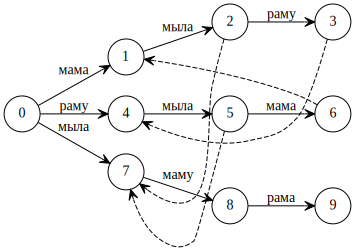

In [39]:
ngram_simple = make_trie([
    ['мама', 'мыла', 'раму'],
    ['раму', 'мыла', 'мама'],
    ['мыла', 'маму', 'рама']
])
calc_suff_links_all(ngram_simple)
to_graph(ngram_simple).Visualize()

In [40]:
class NGramNode:
    def __init__(self, final_weight=float('inf')):
        self.arcs = dict()
        self.backoff = None
        self.final_weight = final_weight
    
    def set_backoff(self, backoff_state, backoff_weight):
        self.backoff = (backoff_state, backoff_weight)
        
    def add_arc(self, nextstate, word_id, neglogprob):
        self.arcs[word_id] = (nextstate, neglogprob)
        
    def set_final(self, final_weight):
        self.final_weight = final_weight

class NGramModel:
    def __init__(self, fst_path, unk_weight=10.0):
        nodes = dict()
        self.start = None
        self.unk_weight = unk_weight
        with open(fst_path) as f:
            for line in f:
                splitted = line.split()
                if len(splitted) <= 2:
                    state = int(splitted[0])
                    if self.start is None:
                        self.start = state
                    
                    if len(splitted) == 2:
                        weight = float(splitted[1])
                    else:
                        weight = 0.0
                        
                    if state not in nodes:
                        nodes[state] = NGramNode(weight)
                    else:
                        nodes[state].set_final(weight)
                else:
                    if len(splitted) == 5:
                        weight = float(splitted[4])
                    else:
                        weight = 0.0
                    from_state, to_state = map(int, splitted[:2])
                    word_id = int(splitted[3])
                    if self.start is None:
                        self.start = from_state
                    
                    if from_state not in nodes:
                        nodes[from_state] = NGramNode()
                    if to_state not in nodes:
                        nodes[to_state] = NGramNode()

                    if word_id == 0:
                        nodes[from_state].set_backoff(to_state, weight)
                    else:
                        nodes[from_state].add_arc(to_state, word_id, weight)
        self.nodes = [None for i in range(max(nodes) + 1)]
        for state, node in nodes.items():
            self.nodes[state] = node
            
    def set_symbol_table(self, symbol_table):
        self.symbol_table = symbol_table
  
    def context_length(self, state):
        tmp = state
        n = 0
        while self.nodes[tmp].backoff is not None:
            n += 1
            tmp = self.nodes[tmp].backoff[0]
        return n
    
    def consume_word(self, state, word):
        result = []
        word_id = word if self.symbol_table is None else (self.symbol_table[word] if word in self.symbol_table else -1)
        current_state = state
        
        while word_id not in self.nodes[current_state].arcs and self.nodes[current_state].backoff is not None:
            result.append(self.nodes[current_state].backoff[1])
            current_state = self.nodes[current_state].backoff[0]
            
        if word_id in self.nodes[current_state].arcs:
            arc = self.nodes[current_state].arcs[word_id]
            result.append(arc[1])
            current_state = arc[0]
        else:
            result.append(self.unk_weight)
        
        return current_state, result
    
def load_symbol_table(table_path):
    table = dict()
    with open(table_path, encoding='utf-8') as f:
        for line in f:
            splitted = line.split()
            if len(splitted) != 2:
                continue
            word, word_id = splitted
            table[word] = int(word_id)
    return table

In [41]:
# для последующего примера понадобится готовая ЯМ в формате текстовом формате fst
# Я воспользовался малой ЯМ из vosk
# http://alphacephei.com/kaldi/models/vosk-model-ru-0.10.zip
vosk_ngram = NGramModel('data/vosk_lm_small/G.txt')
words = load_symbol_table('data/vosk_lm_small/words.txt')
vosk_ngram.set_symbol_table(words)

In [42]:
from IPython.display import Code
def representation(sentence, pos, context, weight, backoff):
    pos += 1
    bos_sentence = ['<s>', *sentence]
    lines = []
    lines.append(' '.join(bos_sentence))
    context_words = [word if pos - i <= context and pos - i >= 0 else ''.join([' ' for i in word]) for i, word in enumerate(bos_sentence)]
    if backoff:
        context_words[pos] = ''.join(['-' for i in context_words[pos]])
    lines.append(' '.join(context_words))
    if weight:
        lines.append(' '.join([f'{weight:{len(word)}.2f}' if pos == i else ''.join([' ' for i in word]) for i, word in enumerate(bos_sentence)]))
    return Code('\n'.join(lines))

In [43]:
def sentence_score(sentence, lm):
    state = vosk_ngram.start
    progress = []
    score = 0.0

    prev = lm.context_length(state)
    for pos, word in enumerate(sentence):
        progress.append(representation(sentence, pos - 1, prev - 1, None, False))
        state, result = lm.consume_word(state, word)
        score += sum(result)
        n = lm.context_length(state)
        for i, weight in enumerate(result[:-1]):
            progress.append(representation(sentence, pos, prev - i, weight, True))
        progress.append(representation(sentence, pos, prev - len(result) + 1, result[-1], False))

        prev = n
    return score, progress

In [44]:
score, progress = sentence_score(['мама', 'мыла', 'раму', 'мылом', 'и', 'хлоркой'], vosk_ngram)

In [45]:
animate_list(progress);

interactive(children=(IntSlider(value=0, description='idx', max=15), Output()), _dom_classes=('widget-interact…

Попробуем добавить языковую модель к нашему корректору ошибок.

In [46]:
tokens, hyp_slices = correct_text_with_beam_search(trie_dict_ru, 'я напсалэто предложеtние с незначительнми ошибкми', vosk_ngram, lm_scale=0.1, beam=7.0)

In [47]:
print(list(recover_best_hyp(tokens)))

['я', 'написал', 'это', 'предложение', 'с', 'незначительными', 'ошибки']


In [48]:
animate_list(hyp_slices, play=True);

Play(value=0)

interactive(children=(IntSlider(value=0, description='idx', max=48), Output()), _dom_classes=('widget-interact…

In [49]:
score, progress = sentence_score(['я', 'написал', 'это', 'предложение', 'с', 'незначительными', 'ошибки'], vosk_ngram)
print(score)
animate_list(progress);

48.1053915512


interactive(children=(IntSlider(value=0, description='idx', max=17), Output()), _dom_classes=('widget-interact…

In [50]:
score, progress = sentence_score(['я', 'написал', 'это', 'предложение', 'с', 'незначительными', 'ошибками'], vosk_ngram)
print(score)
animate_list(progress);

50.7081652512


interactive(children=(IntSlider(value=0, description='idx', max=17), Output()), _dom_classes=('widget-interact…

В данном конкретном случае в ЯМ не оказалось $N$-грамы `незначительными ошибками`, а слово `ошибки` имеет большее правдоподобие, чем `ошибками`.